In [71]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm  # color map
import numpy as np
from scipy.integrate import quad
import math
import warnings
from multiprocessing import Pool
warnings.filterwarnings("ignore")
Mpc = 3.0857e22  # Mega parsec in meters

figuresize = 4
plt.rcParams["figure.figsize"] = (figuresize, figuresize*9.7/12)
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False

# Polarization

In the following will the Stokes parameters $Q$ & $U$ and with these the degree of polarization $P =\sqrt{Q^2+U^2}$ be calculated.

## Parameters definition
define all parameters of the galaxy cluster:

- `r_c` core radius
- `r` border radius
- `n_eo` electron delsity
- `d` distance to the observer

parameters for the velocity profiles VP1 & VP2:
- `VP` selects velocity profile 1 or 2
- `v_c` core velocity for VP1 in units of c
- `r_0` scale radius for VP2
- `v_t` scale velocity for VP2 in units of c

Inclination `inclination`$\in (0, 1/2)$ in units of $\pi$
and rotation along the line of sight `ry`$\in (0, 2\pi)$.
Rotation along z axis `rz` stays zero

In [72]:
r_c = 0.2 * Mpc  # core radius
r = 2.8 * Mpc  # maximum radius

n_eo = 2e4  # central electron density
d = 1e6 * Mpc  # distance

# parameters for VP1 & VP2
VP = 2
v_c = 5e-4/3
r_0 = 1.2 * Mpc
v_t = 8e-3/3

# rotation angles
inclination = 3/8
ry = 0  # rotation angle y-axis - line of sight
rx = np.pi * (1/2 - inclination) # rotation angle x-axis - horizontal axis
rz = 0  # rotation angle z-axis - vertical axis

define parameters for images. Resolution `e` along x axis. `e²` points are integrated -> calculation time increases $\sim e^2$.

But edit resolution with `short`. `short` defines every how many data points the polarization angle is determined

Viewing angles `c`. $r/d$ corresponds to core radius.

In [73]:
short = 16
e = 16*short  # Resolution
c = r/d*1.05  # edge limit (angle). r/d is angle for max. radius r

definde parameters for relative intensity chnage (CMB parameters) then calculate $G_{\nu,\mathrm{pol}}$

In [74]:
sigma_T = 6.652e-29  # thomson cross section
h = 6.626e-34  # planck constant
k_B = 1.381e-23  # Bolzman constant
T = 2.725  # CMB temperature
nu = 160.2e9  # CMB peak frequency
x = h * nu / k_B / T
G_nu_pol = x**2 * math.exp(x) / 2/(math.exp(x) - 1)**2

beta = 2/3  # for beta model

## Function definition

### Electron density
 - `beta_model`
 - `n_e` model from *Vikhlinin*

In [75]:
def beta_model(x, y, z, n_eo, r_c, beta):
    return n_eo*(1+(x**2+y**2+z**2)/r_c**2)**(-beta * 3/2)


def n_e(x, y, z, n_eo, r_c, beta):
    r = np.sqrt(x**2+y**2+z**2)/r_c
    r_s = 1.7 * Mpc
    alpha = 1
    beta = 0.7
    epsilon = 2.5
    return n_eo*r**(-alpha / 2) / (1+r**2)**(3*beta/2 - alpha/2) / (1+(r*r_c/r_s)**3)**(epsilon/2/3)

### Integrands
for Stokes parameters $Q$ and $U$

In [76]:
def integrandQ(t, d, theta, phi, n_eo, r_c, beta, rot):
    v = v_p(theta*t, t-d, phi*t, rot)
    return - 1/10 * sigma_T * G_nu_pol * n_e(theta*t, t-d, phi*t, n_eo, r_c, beta) * np.dot(v, v) * np.cos(2 * np.arctan(v[2]/v[0])) * ((theta)**2 + (1)**2 + (phi)**2)**.5


def integrandU(t, d, theta, phi, n_eo, r_c, beta, rot):
    v = v_p(theta*t, t-d, phi*t, rot)
    return - 1/10 * sigma_T * G_nu_pol * n_e(theta*t, t-d, phi*t, n_eo, r_c, beta) * np.dot(v, v) * np.sin(2 * np.arctan(v[2]/v[0])) * ((theta)**2 + (1)**2 + (phi)**2)**.5

### Velocity profiles and rotation (inclination)

rotationg velocity vector field with VP1 and VP2. Rotated by an rotation matrix to match inclination and rotation along the line of sight defined above

`v_p` sets $v_2=0$ and selects velocity profile

In [77]:
def rotMatrix(rx, ry, rz):  # create rotation matrix
    rotx = [[1, 0, 0],
            [0, np.cos(rx), np.sin(rx)],
            [0, -np.sin(rx), np.cos(rx)]]
    roty = [[np.cos(ry), 0, np.sin(ry)],
            [0, 1, 0],
            [-np.sin(ry), 0, np.cos(ry)]]
    rotz = [[np.cos(rz), np.sin(rz), 0],
            [-np.sin(rz), np.cos(rz), 0],
            [0, 0, 1]]
    # firt x-axis, the z-axis, last y-axis. (Keep z-rot = 0)
    rot = np.matmul(roty, np.matmul(rotz, rotx))
    rot[np.abs(rot) < 1e-5] = 0
    return rot.copy()


def rotate(x, y, z, rot):  # rotate koordinates rot^T * vec(r) = vec(r_rot)
    rotXYZ = np.transpose(
        np.matmul(np.transpose(rot), np.array([[x], [y], [z]])))[0]
    return rotXYZ[0], rotXYZ[1], rotXYZ[2]


def VP1(x, y, z, rot):  # Velocity profile 1 - vctor field, rotated
    x, y, z = rotate(x, y, z, rot)
    v_norm = np.transpose(np.matmul(rot, np.array(
        [[-y], [x], [0]])))[0].copy() / np.sqrt(x**2+y**2)  # normalized field
    r = np.sqrt(x**2+y**2)/r_c  # r/r_c
    v = v_c * r  # profile
    return v * v_norm


def VP2(x, y, z, rot):  # Velocity profile 2 - vctor field, rotated
    x, y, z = rotate(x, y, z, rot)
    v_norm = np.transpose(np.matmul(rot, np.array(
        [[-y], [x], [0]])))[0].copy() / np.sqrt(x**2+y**2)  # normalized field
    r = np.sqrt(x**2+y**2)/r_0  # r/r_0
    v = v_t * r / (1+r**2)  # Profile
    return v * v_norm

def v_p(x, y, z, rot):  # get the velocety part perpendicular to the line of sight
    if VP == 1:
        return VP1(x, y, z, rot) * np.array([1, 0, 1])
    return VP2(x, y, z, rot) * np.array([1, 0, 1])

### polarization vectors

calculate polarization angle and generate fitting vectors propotional to degree of polarization $P$

In [78]:
def polarization_vectors(Q, U, P, short):
    # extract a few points from array
    Ushort = U[::short, ::short].copy()
    Qshort = Q[::short, ::short].copy()
    Pshort = P[::short, ::short].copy()
    # calculate pol. angle theta
    angle = np.arctan(Ushort/Qshort)/2
    angle[Qshort < 0] += np.pi/2
    # generate vecors from angle with the length P
    polvec_x = np.cos(angle)*Pshort
    polvec_y = np.sin(angle)*Pshort
    return polvec_x, polvec_y

### Integradion function
Integrate integrands $Q$ & $U$ with `args`

In [79]:
def integrate_Polarization(args):
    q = np.linspace(0, 0, e)
    Q, U = np.meshgrid(q, q)
    t1, t2, d, Theta, Phi, n_eo, r_c, beta, rot, threats = args[0], args[1],  args[
        2],  args[3],  args[4],  args[5],  args[6],  args[7],  args[8],  args[9]
    Q[Q != 0] = 0
    U[U != 0] = 0
    section_x = args[10]
    section_y = args[11]
    sectionsize = int(e/threats)
    for i in range(sectionsize*section_x, sectionsize*(section_x+1)):
        for j in range(sectionsize*section_y, sectionsize*(section_y+1)):
            theta = Theta[i, j]
            phi = Phi[i, j]
            I = quad(integrandQ, t1[i, j], t2[i, j], args=(
                d, theta, phi, n_eo, r_c, beta, rot))
            Q[i, j] = I[0]
            I = quad(integrandU, t1[i, j], t2[i, j], args=(
                d, theta, phi, n_eo, r_c, beta, rot))
            U[i, j] = I[0]
    return Q.copy(), U.copy()

### muliprocessing

run integration in multiple prozesses to speed up calculation

In [80]:
def integrate_pol_multithreating(t1, t2, d, Theta, Phi, n_eo, r_c, beta, rot, thrts):
    if __name__ == '__main__':
        with Pool() as pool:  # integrate parallel in *#cpu threats* threats
            results = pool.map(integrate_Polarization, [(
                t1, t2, d, Theta, Phi, n_eo, r_c, beta, rot, thrts, i, j) for i in range(thrts) for j in range(thrts)])
    q = np.linspace(0, 0, e)
    Q, U = np.meshgrid(q, q)
    # merge threat results
    for i in range(len(results)):
        q, u = results[i]
        Q += q
        U += u
    # set nan values to 0
    Q[np.isnan(Q)] = 0
    U[np.isnan(U)] = 0
    P = np.sqrt(Q**2 + U**2)
    return Q, U, P

## Calculation
### Limits
Prepare vairables for calculation

calculate limits t1, t2 for integration along the line of sight. The limits match the galaxy cluster radius along the line of sight.

create the rotation maxtix

In [81]:
# generate variables for calculation
theta = np.linspace(-c, c, e)
Theta, Phi = np.meshgrid(theta, theta)
Result = Theta.copy()
t = np.linspace(0, 0, e)
t1, t2 = np.meshgrid(t, t)

# limits for integral. edge of cluster
t1 = (d - np.sqrt(-d**2 * (Phi**2 + Theta**2) + r**2
      * (1 + Phi**2 + Theta**2)))/(1 + Phi**2 + Theta**2)
t2 = (d + np.sqrt(-d**2 * (Phi**2 + Theta**2) + r**2
      * (1 + Phi**2 + Theta**2)))/(1 + Phi**2 + Theta**2)

# calculate rotation matrix
rot = rotMatrix(rx, ry, rz)

### Integrate
execute the calculation for all angles

determin max($|Q|$ and $|U|$) for relative plots

In [82]:
%%time
# calculate stokes parameters
Q, U, P = integrate_pol_multithreating(t1, t2, d, Theta, Phi, n_eo, r_c, beta, rot, 16)
polvec_x, polvec_y = polarization_vectors(Q, U, P, short)

# determin maxmimum value of Q & U
Q_max = np.abs(np.max(Q))
Q_min = np.abs(np.min(Q))
U_max = np.abs(np.max(U))
U_min = np.abs(np.min(U))
max = np.max(np.array([Q_min, Q_max, U_min, U_max]))
# set 0 to nan to plot white
Q[Q == 0] = np.NaN
U[U == 0] = np.NaN
P[P == 0] = np.NaN

CPU times: user 699 ms, sys: 410 ms, total: 1.11 s
Wall time: 2min 46s


## Plots
### svg's
Generate plot for VP1 and VP2. Also a normalized Prot to compare VP1 and VP2 along the x-axis.

Save the plots as svg with latex text.

In [83]:
# edit colorgradient of diagram
colors = cm.get_cmap('coolwarm', 200)
colorcrop = colors(np.linspace(.5, 1, 256))
newcmp = matplotlib.colors.ListedColormap(colorcrop)

plt.contourf(Theta*d/r_c, Phi*d/r_c, P, 100, cmap=newcmp)
plt.colorbar().set_label("\$P\$", labelpad=-5, y=1.08, rotation=0)
plt.quiver(Theta[::short, ::short]*d/r_c, Phi[::short, ::short]
           * d/r_c, polvec_x, polvec_y, pivot='mid', headlength=0, headwidth=1)
plt.xlabel("x / \$r_c\$")
plt.ylabel("z / \$r_c\$")
plt.savefig("figs/P-i="+str(inclination)+"pi_VP"+str(VP)+".svg")
plt.close()

P[np.isnan(P)] = 0
plt.plot(Theta[int(e/2)]*d/r_c, P[int(e/2)], c='black')
plt.xlabel("x / \$r_c\$")
plt.ylabel("\$P\$")
plt.savefig("figs/P2d-i="+str(inclination)+"pi_VP"+str(VP)+".svg")
plt.close()
P[P == 0] = np.NaN

plt.contourf(Theta*d/r_c, Phi*d/r_c, Q, 100,
             cmap='coolwarm', vmin=-max, vmax=max)
plt.xlabel("x / \$r_c\$")
plt.ylabel("z / \$r_c\$")
plt.colorbar().set_label("\$Q/ I_0\$", labelpad=-5, y=1.08, rotation=0)
plt.savefig("figs/Q-i="+str(inclination)+"pi_VP"+str(VP)+".svg")
plt.close()

plt.contourf(Theta*d/r_c, Phi*d/r_c, U, 100,
             cmap='coolwarm', vmin=-max, vmax=max)
plt.xlabel("x / \$r_c\$")
plt.ylabel("z / \$r_c\$")
plt.colorbar().set_label("\$U / I_0\$", labelpad=-5, y=1.08, rotation=0)
plt.savefig("figs/U-i="+str(inclination)+"pi_VP"+str(VP)+".svg")
plt.close()

### show

generate plots again but show them this time (optional export as PNG)

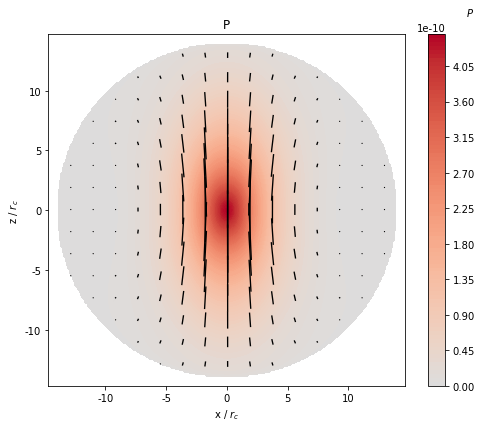

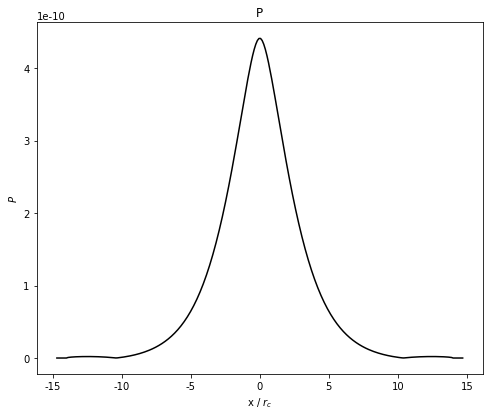

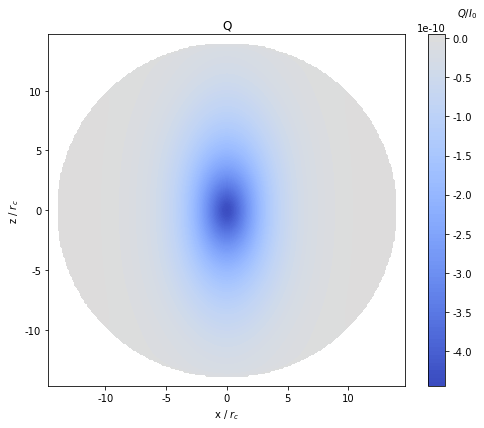

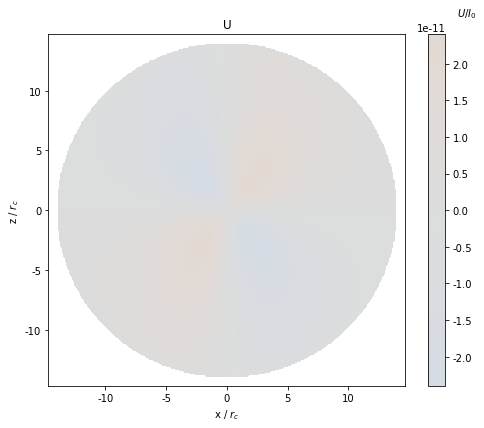

In [84]:
figuresize = 8
plt.rcParams["figure.figsize"] = (figuresize, figuresize*9.7/12)

# plt.subplot(2, 2, 1)
plt.contourf(Theta*d/r_c, Phi*d/r_c, P, 100, cmap=newcmp)
# degree of polarization
plt.colorbar().set_label("$P$", labelpad=-5, y=1.08, rotation=0)
# polarization angles
plt.quiver(Theta[::short, ::short]*d/r_c, Phi[::short, ::short]* d/r_c, polvec_x, polvec_y, pivot='mid', headlength=0, headwidth=1)
plt.xlabel("x / $r_c$")
plt.ylabel("z / $r_c$")
plt.title("P")
plt.show()

# cut
# plt.subplot(2, 2, 2)
P[np.isnan(P)] = 0
plt.plot(Theta[int(e/2)]*d/r_c, P[int(e/2)], c='black')
P[P == 0] = np.NaN
plt.xlabel("x / $r_c$")
plt.ylabel("$P$")
plt.title("P")
plt.show()

# plt.subplot(2, 2, 3)
plt.contourf(Theta*d/r_c, Phi*d/r_c, Q, 100,
             cmap='coolwarm', vmin=-max, vmax=max)
plt.xlabel("x / $r_c$")
plt.ylabel("z / $r_c$")
plt.colorbar().set_label("$Q/ I_0$", labelpad=-5, y=1.08, rotation=0)
plt.title("Q")
plt.show()

# plt.subplot(2, 2, 4)
plt.contourf(Theta*d/r_c, Phi*d/r_c, U, 100,
             cmap='coolwarm', vmin=-max, vmax=max)
plt.xlabel("x / $r_c$")
plt.ylabel("z / $r_c$")
plt.colorbar().set_label("$U / I_0$", labelpad=-5, y=1.08, rotation=0)
plt.title("U")
plt.show()